# Factorization Machine using Batch Gradient Descent

The model equation for a factorization machine of degree d = 2 is defined as:

$\hat{y}(x) := w_0 + \sum_{i = 1} ^ m w_i * x_i + \sum_{i = 1} ^ m \sum_{j = i + 1}^ m <v_i,v_j>x_ix_j$ 

feature X : n x m,  labels Y : 1 x n, n data points  
parameters are w0, W, V   
w0 is real number   
W is m-dim vector   
V is m x k, where k is the hyper parameter   


In [1]:
from BatchGD import *
import cProfile
import torch
from numpy import dot, isinf, isnan, any, sqrt, isreal, real, nan, inf
import numpy as np
import scipy as sp
import processData
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from scipy import sparse as spa
from scipy import stats
import time
from minimize import minimize
from __future__ import division

In [2]:
%load_ext Cython
%load_ext line_profiler
import line_profiler

# Profiling

In [3]:
#loading data
(train_data, y_train, train_users, train_items) = loadData("ua.base")
(test_data, y_test, test_users, test_items) = loadData("ua.test")
v = DictVectorizer()
X_train = v.fit_transform(train_data)[0:2000]
X_test = v.transform(test_data)[0:200]
y_train = y_train[0:2000]
y_train = np.array(y_train)
y_test = y_test[0:200]


X_train = np.array(X_train.todense())
X_test = np.array(X_test.todense())
X_train = X_train.astype(np.float32, copy=False)
X_test = X_test.astype(np.float32, copy=False)
print(X_train.__class__, X_train.shape)
print(y_train.__class__, y_train.shape)
print(X_test.__class__, X_test.shape)
print(y_test.__class__, y_test.shape)

<class 'numpy.ndarray'> (2000, 2623)
<class 'numpy.ndarray'> (2000,)
<class 'numpy.ndarray'> (200, 2623)
<class 'numpy.ndarray'> (200,)


In [4]:
k = 30
nb_epochs = 4
learning_rate = 0.1
n, m = X_train.shape
w0 = np.random.rand()
W  = np.random.rand(m).astype(np.float32)
V  = np.random.rand(m, k).astype(np.float32)
H = compress(w0, W, V, m, k)
n,m = X_train.shape

In [5]:
%timeit -n2 -r3 gradHVec(H, X_train,y_train,m, k, 0.05)

209 ms ± 26.2 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)


In [6]:
%%cython -a -f --compile-args=-DCYTHON_TRACE=1
cimport cython
cimport numpy as np
import numpy as np
from minimize import minimize

DTYPE = np.float32

ctypedef np.float32_t DTYPE_t

@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
def predictionForOnec(np.ndarray x, np.ndarray x2, float w0, np.ndarray W, np.ndarray V_T, np.ndarray V2_T):
    cdef float res1,res2,res3
    res1 = np.sum(V_T.dot(x) ** 2)
    res2 = np.sum(V2_T.dot(x2))
    res3 = W.dot(x)

    return w0 + res3 + 0.5 * (res1 - res2)

@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
def predictionc(np.ndarray X, float w0, np.ndarray W, np.ndarray V):
    cdef np.ndarray res1, res2, t
    res1 = X.dot(V)
    res1 = 0.5 * np.sum(res1**2, axis = 1)
    res2 = (X**2).dot(V**2)
    res2 = 0.5 * np.sum(res2, axis = 1)
    t = X.dot(W)
    res1 -= res2
    res1 += w0
    res1 += t
    return res1

@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
def extractc(np.ndarray H, int m, int k):
    cdef double w0 = H[0]
    cdef np.ndarray W = H[1:(m+1)]
    cdef np.ndarray V = (H[(m+1):]).reshape(m,k)
    return w0, W, V

@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
def compressc(float w0, np.ndarray W,\
              np.ndarray V, int m, int k):
    cdef np.ndarray res = np.array([w0])
    res = np.append(res, W)
    res = np.append(res, V.flatten())
    return res    

@cython.boundscheck(False) # turn off bounds-checking for entire function
@cython.wraparound(False)  # turn off negative index wrapping for entire function
def gradHVecc(np.ndarray H, np.ndarray X, np.ndarray Y, int m, int k,float reg_weight):
    cdef int i,factor,times
    cdef float w0
    cdef np.ndarray W, pred, diff,dLdWi
    cdef np.ndarray V, dLdV
    cdef int n = X.shape[0]
    cdef float dLdw0
    cdef np.ndarray XVT,xT,diffT,x2,v_ifXDiff,Xv_ifX

    Y = np.array(Y)
    w0, W, V= extractc(H, m, k)

    diff = Y - ( predictionc(X, w0, W, V) ).ravel()

    dLdw0 = - np.sum(diff) * 2 / n
    dLdWi = -2.0/n * (diff.dot(X)).flatten() + 2 * reg_weight * W
    
    XVT = X.dot(V).T
    xT = X.T
    diffT = diff[:, np.newaxis]
    x2 = X ** 2
    dLdV = np.array([])
    factor = 50
    times = int(n / factor)
    for i in range(times):
        if i < times - 1:
            v_ifXDiff = np.einsum('ij, jk -> jki', x2[i*int(n/times):(i+1)*int(n/times),:], V[:,i*int(k/times):(i+1)*int(k/times)])
            Xv_ifX = np.einsum('ij, kj -> ikj', xT[:,i*int(n/times):(i+1)*int(n/times)], XVT[i*int(k/times):(i+1)*int(k/times),i*int(n/times):(i+1)*int(n/times)])
            v_ifXDiff -= Xv_ifX
            dLdV = np.append(dLdV, np.einsum('ijk , kl ->ijl', v_ifXDiff, diffT[i*int(n/times):(i+1)*int(n/times)]))
        else:
            v_ifXDiff = np.einsum('ij, jk -> jki', x2[i*int(n/times):,:], V[:,i*int(k/times):])
            Xv_ifX = np.einsum('ij, kj -> ikj', xT[:,i*int(n/times):], XVT[i*int(k/times):,i*int(n/times):])
            v_ifXDiff -= Xv_ifX
            dLdV = np.append(dLdV, np.einsum('ijk , kl ->ijl', v_ifXDiff, diffT[i*int(n/times):]))

    dLdV = dLdV.reshape(m,k)
    dLdV *= 2/n
    
    return compressc(dLdw0, dLdWi, dLdV, m, k)

def lossHc(np.ndarray H, np.ndarray X, np.ndarray Y, int m, int k,float reg_weight):
    cdef int n = Y.size
    cdef float w0, regularizer, loss
    cdef np.ndarray W, V
    w0, W, V = extractc(H, m, k)
    loss = np.mean((Y - predictionc(X, w0, W, V)) ** 2)
    regularizer = reg_weight * W.dot(W)
    return loss + regularizer

In [2]:
def runMinVecc(X,Y, w0, W, V, k, reg_weight = 0.05):
    n = X.shape[0]
    m = X.shape[1]
    H = compressc(w0, W, V, m, k)
    [newH, fx, i] = minimize(H, lossHc, gradHVecc, (X, Y, m, k, reg_weight),maxnumlinesearch=8, verbose=False)
    H = newH
    
    return extractc(H, m, k)

In [ ]:
%timeit -n2 -r3 runMinVecc(X_train,y_train,w0, W, V, k)

In [9]:
%timeit -n2 -r3 gradHVec(H, X_train,y_train,m, k, 0.05)

179 ms ± 7.89 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)


In [11]:
%timeit -n2 -r3 gradHVecc(H, X_train,y_train,m, k, 0.05)
# %lprun -f gradHVecc gradHVecc(H, X_train,y_train,m, k, 0.05)

184 ms ± 9.83 ms per loop (mean ± std. dev. of 3 runs, 2 loops each)


In [ ]:
cProfile.run('runMinVecc(X_train,y_train,w0, W, V, k)')

In [6]:
cProfile.run('runMinVec(X_train,y_train,w0, W, V, k)')

         20800 function calls in 6.369 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    6.369    6.369 <string>:1(<module>)
       27    0.000    0.000    0.004    0.000 BatchGD.py:122(compress)
       53    0.000    0.000    0.001    0.000 BatchGD.py:130(extract)
       26    0.001    0.000    1.910    0.073 BatchGD.py:140(lossH)
       52    0.469    0.009    3.756    0.072 BatchGD.py:24(prediction)
       26    0.357    0.014    4.125    0.159 BatchGD.py:262(gradHVec)
        1    0.001    0.001    6.369    6.369 BatchGD.py:306(runMinVec)
      156    0.000    0.000    0.011    0.000 _methods.py:31(_sum)
       14    0.000    0.000    0.000    0.000 _methods.py:37(_any)
     3120    0.002    0.000    0.916    0.000 einsumfunc.py:703(einsum)
     1094    0.001    0.000    0.004    0.000 fromnumeric.py:1364(ravel)
      156    0.002    0.000    0.013    0.000 fromnumeric.py:1710(sum)
       14

# Using dataset from Steffen Rendle's Factorization Machine Paper

In [6]:
nb_epochs = 300
k = 4
X = np.array([
    [1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1],
    [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0.5, 0.5],
    [0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0.5, 0, 0.5],
    [0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
    [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0.5, 0.5, 0]
    ])
Y = np.array([5, 3, 1, 4, 5, 1, 5])
print("X:", X.shape)
print("y:", Y.shape)

X: (7, 13)
y: (7,)


In [8]:
n, m = X.shape
w0 = np.random.rand()
W  = np.random.rand(m)
V  = np.random.rand(m, k)
epo_losses = []
correctness = []
for i in range(nb_epochs):
    pred = prediction(X, w0, W, V)
    epo_losses.append(L(Y,pred,W))
#     print("correctness is:{}".format(crtness(Y, pred)))
    correctness.append(crtness(Y, pred))
    w0, W, V = runMinVec(X,Y,w0, W, V, k)

In [9]:
def fm(X, Y, w0, W, V, k, nb_epochs):
    for i in range(nb_epochs):
        pred = prediction(X, w0, W, V)
        epo_losses.append(L(Y,pred,W))
    #     print("correctness is:{}".format(crtness(Y, pred)))
        correctness.append(crtness(Y, pred))
        w0, W, V = runMinVec(X,Y,w0, W, V, k)

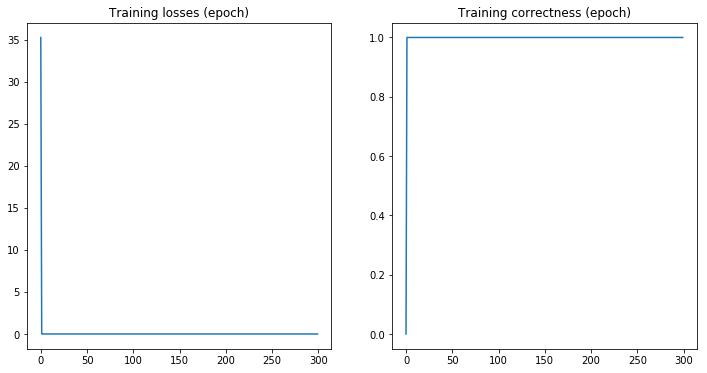

In [10]:
plt.figure(figsize = (12,6))
plt.subplot(121)
plt.plot(range(len(epo_losses)), epo_losses)
plt.title("Training losses (epoch)")
plt.subplot(122)
plt.plot(range(len(correctness)), correctness)
plt.title("Training correctness (epoch)")
plt.show()

# 100k Dataset

In [11]:
def loadData(filename,path="../ml-100k/"):
    data = []
    y = []
    users=set()
    items=set()
    with open(path+filename) as f:
        for line in f:
            (user,movieid,rating,ts)=line.split('\t')
            data.append({ "user_id": str(user), "movie_id": str(movieid)})
            y.append(float(rating))
            users.add(user)
            items.add(movieid)

    return (data, np.array(y), users, items)

(train_data, y_train, train_users, train_items) = loadData("ua.base")
(test_data, y_test, test_users, test_items) = loadData("ua.test")
v = DictVectorizer()
X_train = v.fit_transform(train_data)
X_test = v.transform(test_data)
y_train = y_train
y_train = np.array(y_train)
y_test = y_test

X_train = np.array(X_train.todense())
X_test = np.array(X_test.todense())
print(X_train.__class__, X_train.shape)
print(y_train.__class__, y_train.shape)
print(X_test.__class__, X_test.shape)
print(y_test.__class__, y_test.shape)

<class 'numpy.ndarray'> (90570, 2623)
<class 'numpy.ndarray'> (90570,)
<class 'numpy.ndarray'> (9430, 2623)
<class 'numpy.ndarray'> (9430,)


In [12]:
k = 10
nb_epochs = 4
n, m = X_train.shape
w0 = np.random.rand()
W  = np.random.rand(m)
V  = np.random.rand(m, k)
epo_losses = []
correctness = []
rmse = []
avg_dist = []
mode,_ = stats.mode(y_train)
mode_pred = np.full(len(y_test), mode , dtype = int)
mode_crt = crtness(y_test, mode_pred)
mode_rmse = RMSE(y_test, mode_pred)
mode_avgdist = avgdist(y_test, mode_pred)
mean_pred = np.full(len(y_test), np.mean(y_train))
mean_crt = crtness(y_test, mean_pred)
mean_rmse = RMSE(y_test, mean_pred)
mean_avgdist = avgdist(y_test, mean_pred)

In [ ]:
for i in range(nb_epochs):
    print("running epoch{}".format(i))
    w0, W, V = runMinVec(X_train,y_train,w0, W, V, k)
    pred = prediction(X_test, w0, W, V)
    print("loss is:{}".format(L(y_test, pred,W)))
    epo_losses.append(L(y_test, pred, W))
#     print("y_test: ", y_test, "pred: ", pred)
#     print("correctness is:{}".format(crtness(y_test, pred)))
    correctness.append(crtness(y_test, pred))
    rmse.append(RMSE(y_test, pred))
    avg_dist.append(avgdist(y_test, pred))

running epoch0
loss is:1.7508376060204363
running epoch1


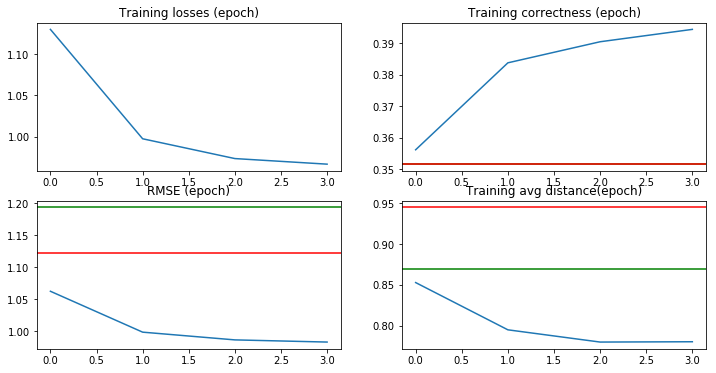

In [6]:
plt.figure(figsize = (12,6))
plt.subplot(221)
plt.plot(range(len(epo_losses)), epo_losses)
plt.title("Training losses (epoch)")
plt.subplot(222)
plt.plot(range(len(correctness)), correctness)
plt.axhline(y = mode_crt, xmin = 0, xmax = len(correctness) - 1, color = 'green' )
plt.axhline(y = mean_crt, xmin = 0, xmax = len(correctness) - 1, color = 'red' )
plt.title("Training correctness (epoch)")
plt.subplot(223)
plt.plot(range(len(rmse)), rmse)
plt.axhline(y = mode_rmse, xmin = 0, xmax = len(correctness) - 1, color = 'green' )
plt.axhline(y = mean_rmse, xmin = 0, xmax = len(correctness) - 1, color = 'red' )
plt.title("RMSE (epoch)")
plt.subplot(224)
plt.plot(range(len(avg_dist)), avg_dist)
plt.axhline(y = mode_avgdist, xmin = 0, xmax = len(correctness) - 1, color = 'green' )
plt.axhline(y = mean_avgdist, xmin = 0, xmax = len(correctness) - 1, color = 'red' )
plt.title("Training avg distance(epoch)")
plt.show()

In [8]:
for i in range(nb_epochs):
    print("running epoch{}".format(i))
    w0, W, V = runMinVec(X_train,y_train,w0, W, V, k)
    pred = prediction(X_test, w0, W, V)
    print("loss is:{}".format(L(y_test, pred,W)))
    epo_losses.append(L(y_test, pred, W))
#     print("y_test: ", y_test, "pred: ", pred)
#     print("correctness is:{}".format(crtness(y_test, pred)))
    correctness.append(crtness(y_test, pred))
    rmse.append(RMSE(y_test, pred))
    avg_dist.append(avgdist(y_test, pred))

running epoch0
loss is:0.9727635803191322
running epoch1
loss is:0.9692819932591663
running epoch2
loss is:0.9789602612758954
running epoch3
loss is:0.9754503484395941


In [9]:
print(rmse)

[1.0624635199951209, 0.99860166658170457, 0.986520629011302, 0.98313191491147389, 0.98613261294406751, 0.98441581117343757, 0.98923565888202036, 0.98753182231499437]


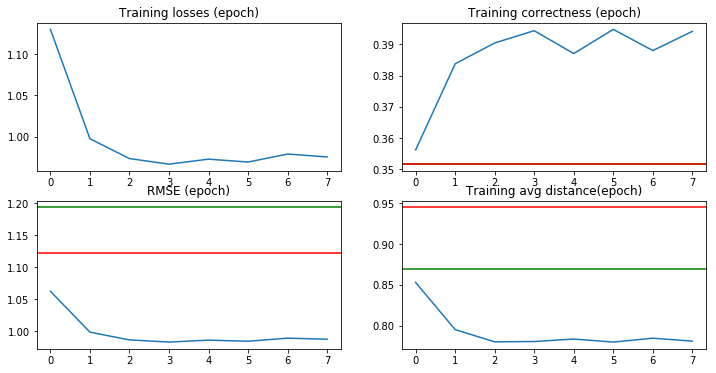

In [10]:
plt.figure(figsize = (12,6))
plt.subplot(221)
plt.plot(range(len(epo_losses)), epo_losses)
plt.title("Training losses (epoch)")
plt.subplot(222)
plt.plot(range(len(correctness)), correctness)
plt.axhline(y = mode_crt, xmin = 0, xmax = len(correctness) - 1, color = 'green' )
plt.axhline(y = mean_crt, xmin = 0, xmax = len(correctness) - 1, color = 'red' )
plt.title("Training correctness (epoch)")
plt.subplot(223)
plt.plot(range(len(rmse)), rmse)
plt.axhline(y = mode_rmse, xmin = 0, xmax = len(correctness) - 1, color = 'green' )
plt.axhline(y = mean_rmse, xmin = 0, xmax = len(correctness) - 1, color = 'red' )
plt.title("RMSE (epoch)")
plt.subplot(224)
plt.plot(range(len(avg_dist)), avg_dist)
plt.axhline(y = mode_avgdist, xmin = 0, xmax = len(correctness) - 1, color = 'green' )
plt.axhline(y = mean_avgdist, xmin = 0, xmax = len(correctness) - 1, color = 'red' )
plt.title("Training avg distance(epoch)")
plt.show()